In [ ]:
import os
import re
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from nltk.corpus import stopwords
import logging


import nltk
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

BASE_URL = "https://www.gutenberg.org"

def get_bookshelves():
    """
    Fetches all bookshelves (genres) from Project Gutenberg.
    """
    response = requests.get(f"{BASE_URL}/ebooks/bookshelf/")
    if response.status_code != 200:
        raise Exception("Failed to fetch the bookshelves page.")

    soup = BeautifulSoup(response.text, 'html.parser')
    bookshelves = {}
    for link in soup.find_all("a", href=True):
        if "/ebooks/bookshelf/" in link['href']:
            genre_name = link.text.strip()
            genre_url = BASE_URL + link['href']
            bookshelves[genre_name] = genre_url

    logger.info(f"Found {len(bookshelves)} bookshelves.")
    return bookshelves

def fetch_books_from_shelf(shelf_url, output_folder, num_books=10,genre_name=None):
    """
    Fetches books from a specific bookshelf URL, removes non-English books, 
    and cleans the title to exclude download numbers or extra details.
    """
    response = requests.get(shelf_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch books from bookshelf: {shelf_url}")

    soup = BeautifulSoup(response.text, 'html.parser')
    book_links = []
    seen_urls = set()

    # Extract book links
    for link in soup.find_all("a", href=True):
        if link['href'].startswith("/ebooks/") and link['href'].split("/")[-1].isdigit():
            full_url = f"{BASE_URL}{link['href']}.txt.utf-8"
            if full_url not in seen_urls:
                seen_urls.add(full_url)
                raw_title = link.text.strip()
                
                # Remove downloads information and filter non-English books
                if "(French)" in raw_title or "(German)" in raw_title or "(Spanish)" in raw_title:
                    logger.info(f"Skipping non-English book: {raw_title}")
                    continue

                # Clean title to remove extra details like downloads
                sanitized_title = re.sub(r"\s*\d+\s*downloads$", "", raw_title).strip()
                sanitized_title = re.sub(r'[\\/*?:"<>|]', "_", sanitized_title)
                sanitized_title = re.sub(r'\s+', ' ', sanitized_title).strip()  # Remove extra spaces
                
                book_links.append({
                    "title": sanitized_title,
                    "url": full_url
                })

    logger.info(f"Found {len(book_links)} books in the selected bookshelf.")
    if len(book_links) == 0:
        logger.warning("No books found in this bookshelf.")
        return []

    # Select a limited number of books
    selected_books = random.sample(book_links, min(num_books, len(book_links)))

    # Prepare output folder
    os.makedirs(output_folder, exist_ok=True)
    raw_folder = os.path.join(output_folder, "raw")
    os.makedirs(raw_folder, exist_ok=True)

    metadata = []
    for book in selected_books:
        title = book["title"]
        raw_file_path = os.path.join(raw_folder, f"{title}.txt")
        if download_gutenberg_text(book["url"], raw_file_path):
            metadata.append({"title": book["title"], "url": book["url"], "genre": genre_name})

    # Save metadata
    if metadata:
        metadata_df = pd.DataFrame(metadata)
        metadata_df.to_csv(os.path.join(output_folder, "metadata.csv"), index=False)
        logger.info(f"Metadata saved to {output_folder}/metadata.csv")
    return metadata



def download_gutenberg_text(url, save_path):
    """
    Downloads text from a Project Gutenberg URL and saves it locally.
    """
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'w', encoding='utf-8') as file:
            file.write(response.text)
        logger.info(f"Downloaded: {save_path}")
        return True
    else:
        logger.error(f"Failed to download: {url}")
        return False

def preprocess_books(raw_folder, clean_folder):
    """
    Preprocesses all raw text files: cleans the text and extracts linguistic features.
    """
    os.makedirs(clean_folder, exist_ok=True)
    features = []

    for file_name in os.listdir(raw_folder):
        if not file_name.endswith(".txt"):
            continue

        raw_file_path = os.path.join(raw_folder, file_name)
        with open(raw_file_path, 'r', encoding='utf-8') as raw_file:
            raw_text = raw_file.read()

        # Clean text
        cleaned_text = clean_text(raw_text)
        clean_file_path = os.path.join(clean_folder, file_name)
        with open(clean_file_path, 'w', encoding='utf-8') as clean_file:
            clean_file.write(cleaned_text)
        
        # Extract linguistic features
        tokens = word_tokenize(cleaned_text)
        sentences = sent_tokenize(cleaned_text)
        word_freq = Counter(tokens)
        vocab_richness = len(set(tokens)) / len(tokens) if tokens else 0
        avg_sentence_length = sum(len(word_tokenize(s)) for s in sentences) / len(sentences) if sentences else 0

        # Store features

        nltk.download('stopwords')

#Get the list of English stopwords
        filtered_word_freq = Counter({word: freq for word, freq in word_freq.items() if word.isalpha() and word not in stop_words})
        features.append({
            "file_name": file_name,
            "vocab_richness": vocab_richness,
            "avg_sentence_length": avg_sentence_length,
            "num_sentences": len(sentences),
            "num_words": len(tokens),
            "most_common_word": filtered_word_freq.most_common(1)[0][0] if word_freq else None
        })
        logger.info(f"Processed: {file_name}")

    # Save features to CSV
    if features:
        features_df = pd.DataFrame(features)
        features_df.to_csv(os.path.join(clean_folder, "linguistic_features.csv"), index=False)
        logger.info(f"Linguistic features saved to {clean_folder}/linguistic_features.csv")
    else:
        logger.warning("No features extracted; the dataset might be empty.")

def clean_text(text):
    """
    Cleans the raw text by removing headers, footers, and extra spaces.
    """
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    start_index = text.find("*** START OF THIS PROJECT GUTENBERG EBOOK")
    end_index = text.find("*** END OF THIS PROJECT GUTENBERG EBOOK")
    if start_index != -1 and end_index != -1:
        text = text[start_index + len("*** START OF THIS PROJECT GUTENBERG EBOOK"):end_index]
    return text.strip()

if __name__ == "__main__":
    # Get bookshelves
    bookshelves = get_bookshelves()

    # Choose genres to process
    selected_genres = ["Science Fiction", "Fantasy", "Mystery Fiction"]
    output_folder = "gutenberg_bookshelf_data"

    for genre in selected_genres:
        if genre in bookshelves:
            logger.info(f"Processing genre: {genre}")
            shelf_url = bookshelves[genre]
            genre_folder = os.path.join(output_folder, genre.replace(" ", "_"))
            metadata = fetch_books_from_shelf(shelf_url, genre_folder, num_books=5,genre_name=genre)
            if metadata:
                preprocess_books(os.path.join(genre_folder, "raw"), os.path.join(genre_folder, "cleaned"))

In [6]:
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if you haven't already
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Read and preprocess all books
book_texts = []
book_titles = []
base_dir = 'gutenberg_bookshelf_data'
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):  #Skip if 'cleaned' folder not exist
        continue
for filename in os.listdir(genre_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(genre_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            preprocessed_text = preprocess_text(text)
            book_texts.append(preprocessed_text)
            book_titles.append(f"{genre_folder}: {filename.replace('.txt', '')}")  # Include genre in the title

print(f"Processed texts: {book_titles}")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yanzheng\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed texts: ['Science_Fiction: A Princess of Mars Edgar Rice Burroughs', 'Science_Fiction: Second Variety Philip K. Dick', 'Science_Fiction: The Big Trip Up Yonder Kurt Vonnegut', 'Science_Fiction: The Country of the Blind, and Other Stories H. G. Wells', 'Science_Fiction: The Eyes Have It Philip K. Dick', 'Science_Fiction: The Hanging Stranger Philip K. Dick', 'Science_Fiction: The Lani People Jesse F. Bone', 'Science_Fiction: The Lost World Arthur Conan Doyle', 'Science_Fiction: The Marching Morons C. M. Kornbluth', 'Science_Fiction: The Mysterious Island Jules Verne', 'Science_Fiction: The Time Machine H. G. Wells', 'Science_Fiction: The War of the Worlds H. G. Wells', 'Science_Fiction: Twenty Thousand Leagues Under the Seas_ An Underwater Tour of the World Jules Verne', 'Science_Fiction: With the Night Mail_ A Story of 2000 A.D. Rudyard Kipling']


In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import os

# Base directory containing the genres
base_dir = 'gutenberg_bookshelf_data'

# Process each genre
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Collect texts for the current genre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())

    if not book_texts:  # Skip genres with no books
        print(f"No texts found for genre: {genre_folder}")
        continue

    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
    lda.fit(X)

    # Display the topics for the current genre
    print(f"\n--- Topics for Genre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[-10:][::-1]]))



--- Topics for Genre: Fantasy ---
Topic 1:
said little dorothy man great gutenberg people did like know
Topic 2:
thou robin little thee quoth said good thy john hood
Topic 3:
myles thou said thee earl lord gascoyne sir thy time
Topic 4:
said thou went came thee son man arthur thy men
Topic 5:
sir king said knight thou shall great thee came lord

--- Topics for Genre: Mystery_Fiction ---
Topic 1:
said time sir percival mr count miss house man shall
Topic 2:
verloc mr mrs man said like did inspector chief ossipon
Topic 3:
said man like got good know came did saw old
Topic 4:
mr said time miss house franklin say sergeant room way
Topic 5:
said time little say great man long gutenberg did project

--- Topics for Genre: Science_Fiction ---
Topic 1:
said kennon gutenberg project work alexander ll like know man
Topic 2:
said man little came like time saw way did great
Topic 3:
pencroft harding island herbert cyrus said engineer neb replied spilett
Topic 4:
dejah thoris great sola warriors ma

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split

# Candidate topic counts
candidate_topic_counts = [10, 30, 50, 70]

# Parameters for LDA
iterations = 1000  # Number of iterations
burnin = 1000  # Burn-in period
# Assume `book_texts` is a list of preprocessed texts (tokenized and cleaned)
# Example: book_texts = [['word1', 'word2', ...], ['word3', 'word4', ...], ...]

# Create a Gensim dictionary and corpus
dictionary = Dictionary(book_texts)
corpus = [dictionary.doc2bow(text) for text in book_texts]

# Split into training and holdout sets
train_corpus, holdout_corpus = train_test_split(corpus, test_size=0.2, random_state=42)
results = []

for num_topics in candidate_topic_counts:
    # Train LDA model on the training corpus
    lda_model = LdaModel(
        corpus=train_corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        iterations=iterations,
        passes=10,
        random_state=42
    )
perplexity = lda_model.log_perplexity(holdout_corpus)
    
    # Store results
results.append({
        "num_topics": num_topics,
        "perplexity": np.exp(-perplexity)  # Convert log-perplexity to perplexity
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.scatter(results_df['num_topics'], results_df['perplexity'], color='blue', label='Perplexity')
plt.xlabel('Candidate Number of Topics')
plt.ylabel('Holdout Perplexity')
plt.title('Holdout Perplexity vs Topic Count ')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'gensim'


--- Word Clouds for Genre: Fantasy ---


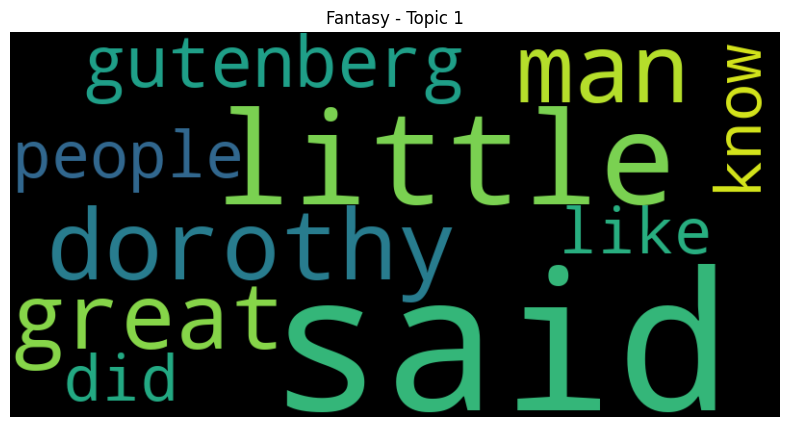

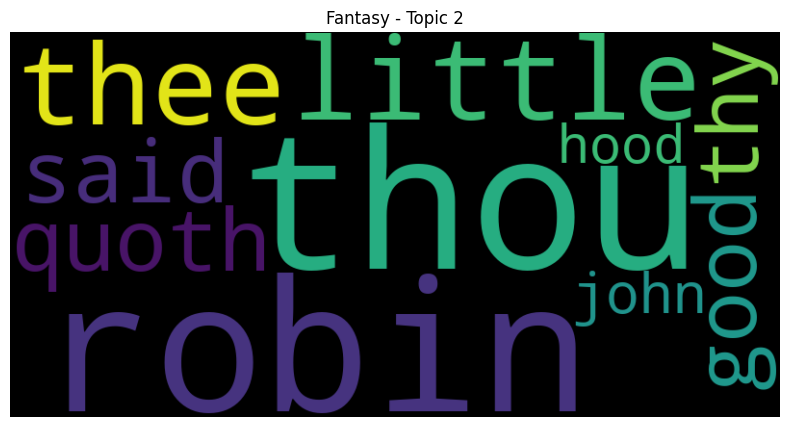

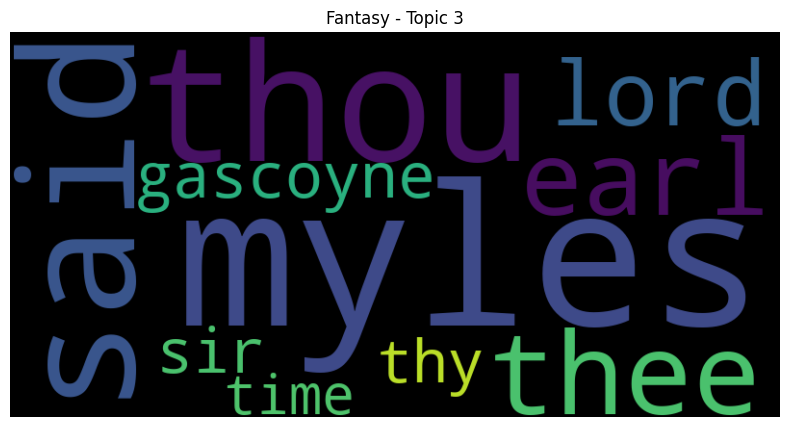

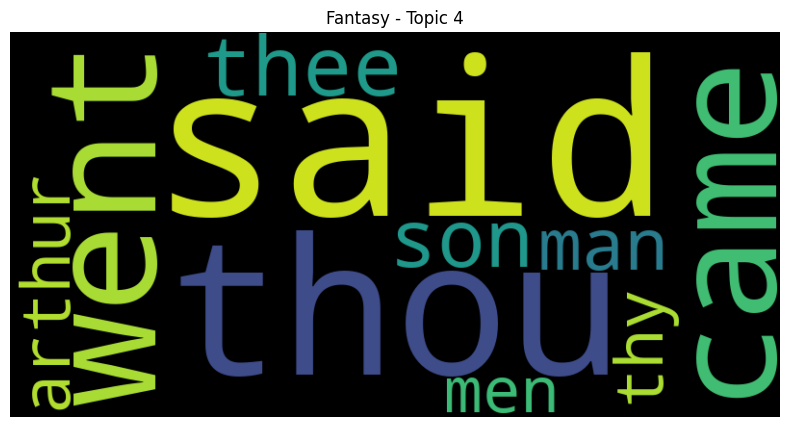

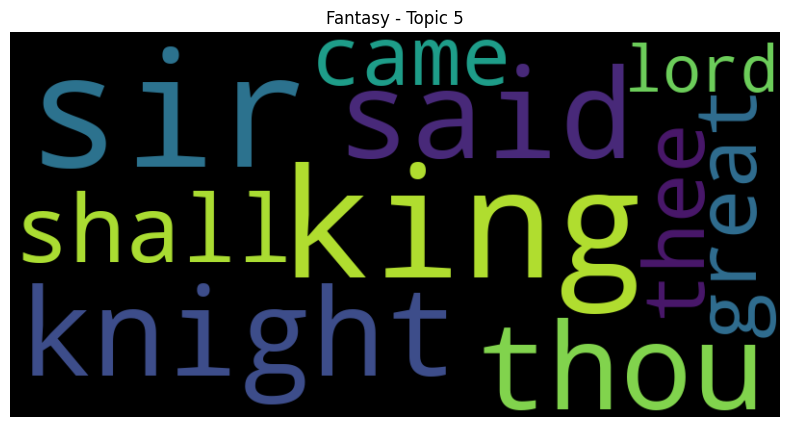


--- Word Clouds for Genre: Mystery_Fiction ---


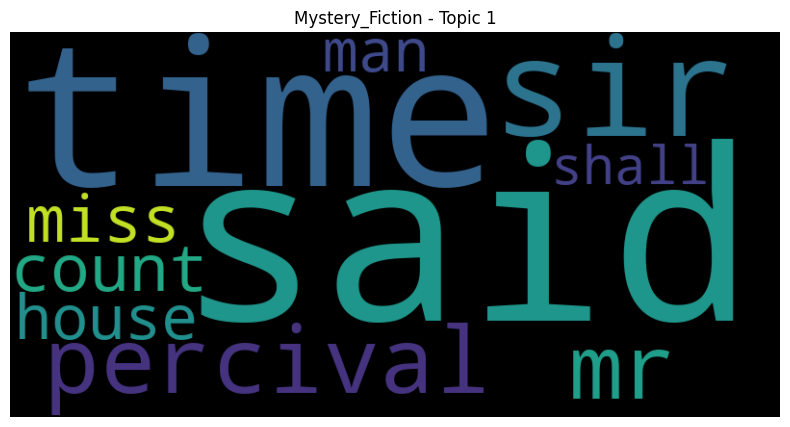

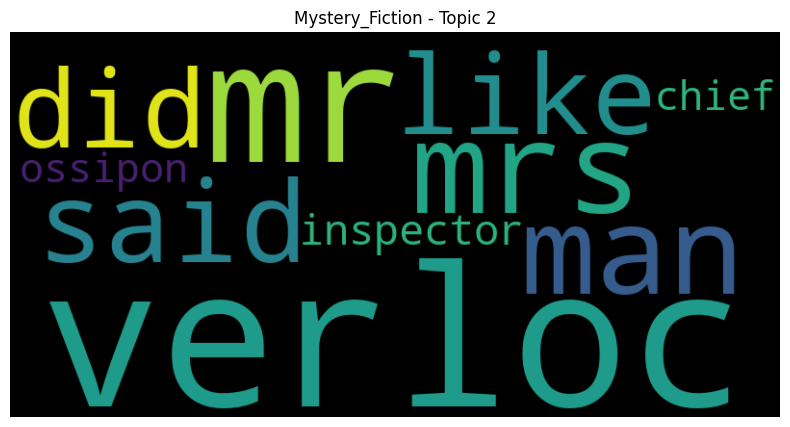

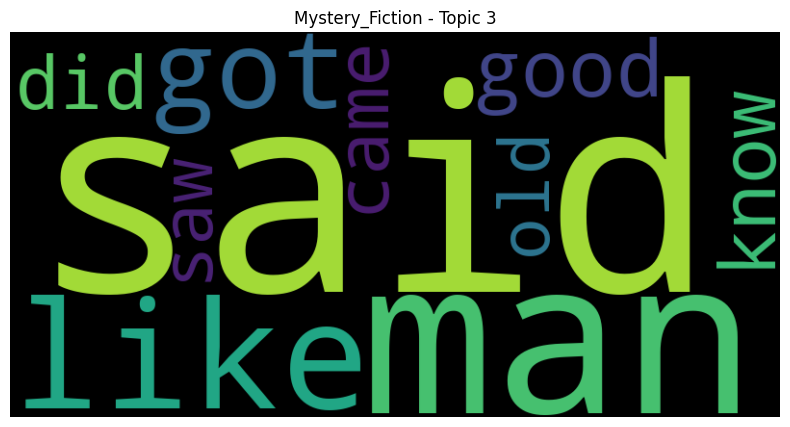

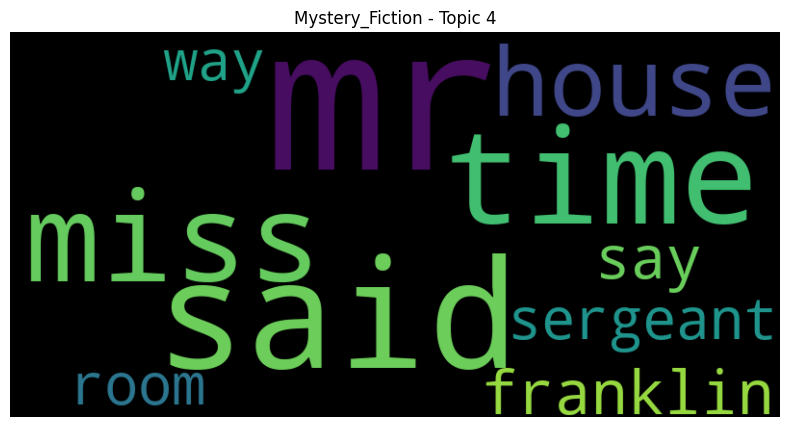

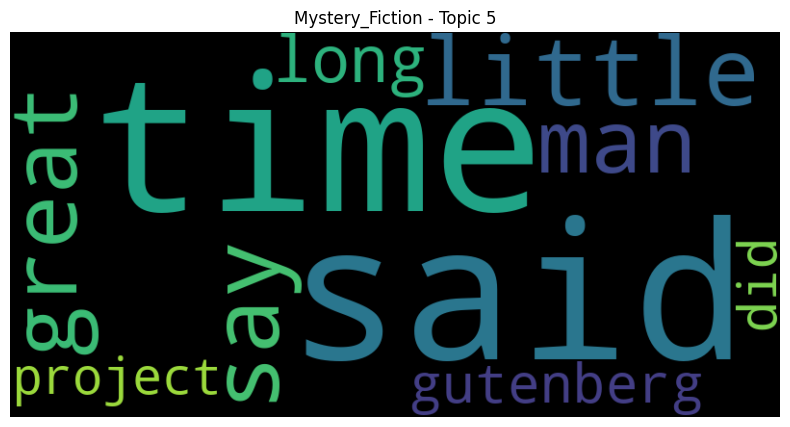


--- Word Clouds for Genre: Science_Fiction ---


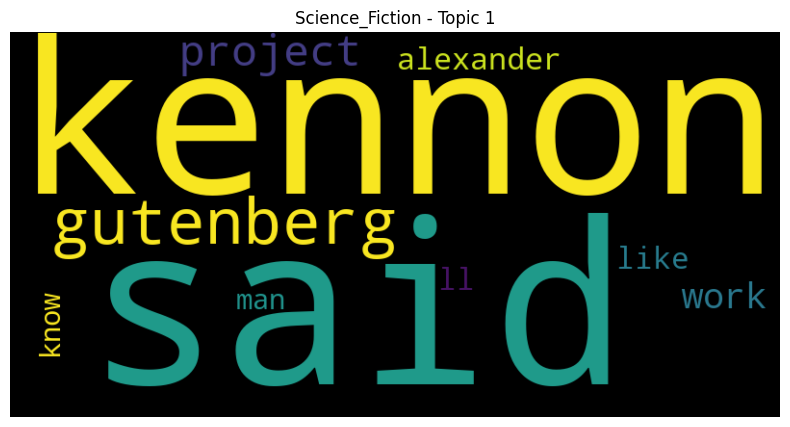

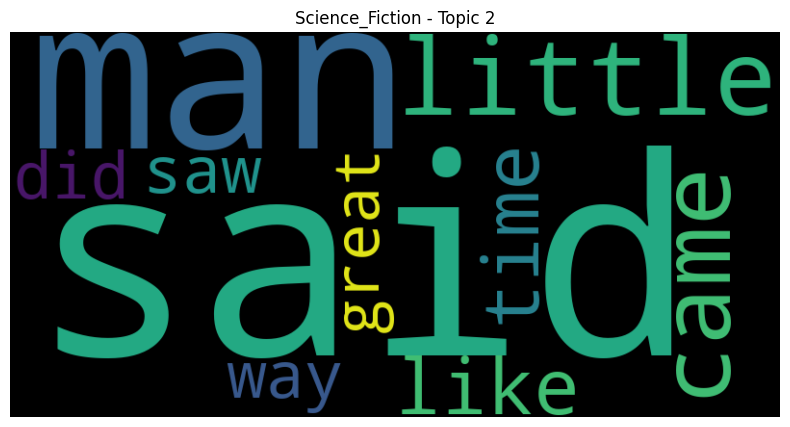

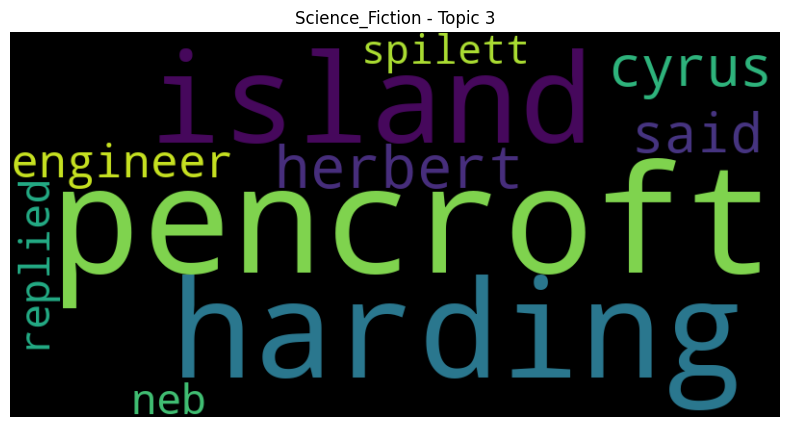

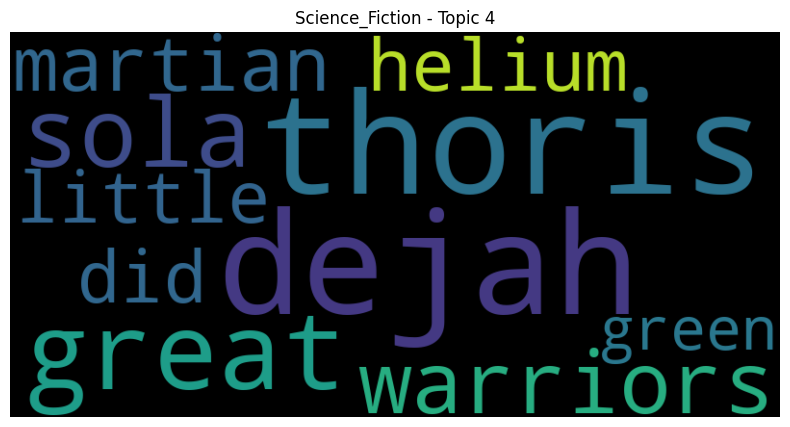

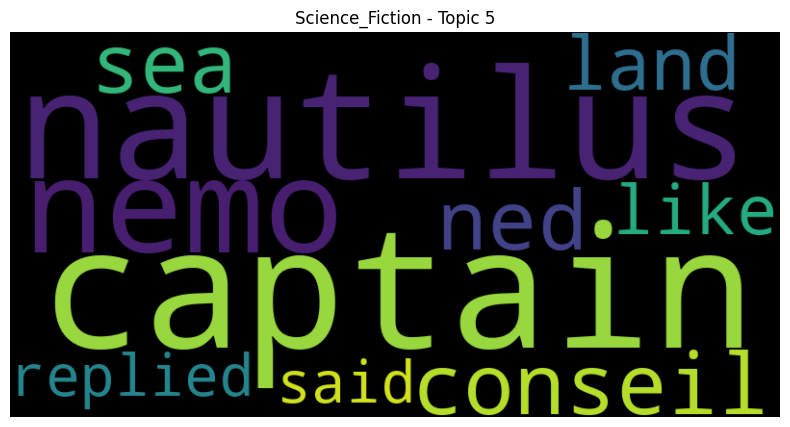

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Base directory containing the genres
base_dir = 'gutenberg_bookshelf_data'

# Process each genre
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Collect texts for the current genre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())

    if not book_texts:  # Skip genres with no books
        print(f"No texts found for genre: {genre_folder}")
        continue

    # Vectorize the text using CountVectorizer
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
    lda.fit(X)

    # Generate word clouds for the current genre
    print(f"\n--- Word Clouds for Genre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        topic_words = {words[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 words
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(topic_words)
        
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{genre_folder} - Topic {topic_idx + 1}")
        plt.show()



--- Topics for Subgenre: Fantasy ---
Topic 1:
king shall lord knight come says know great lady love


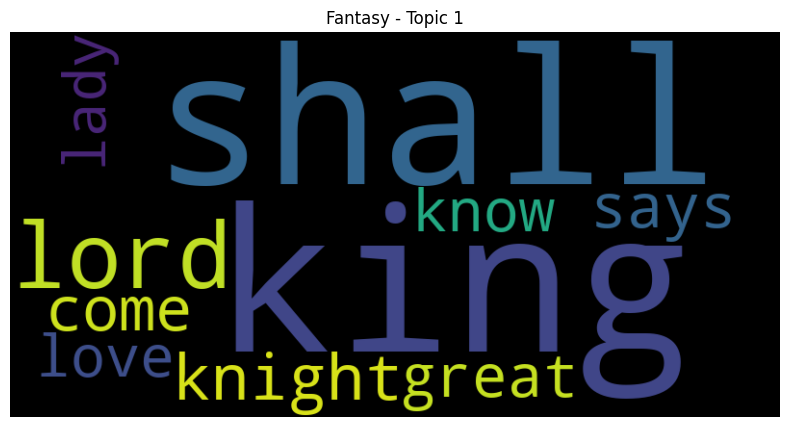

Topic 2:
thou said thee went came thy son man men arthur


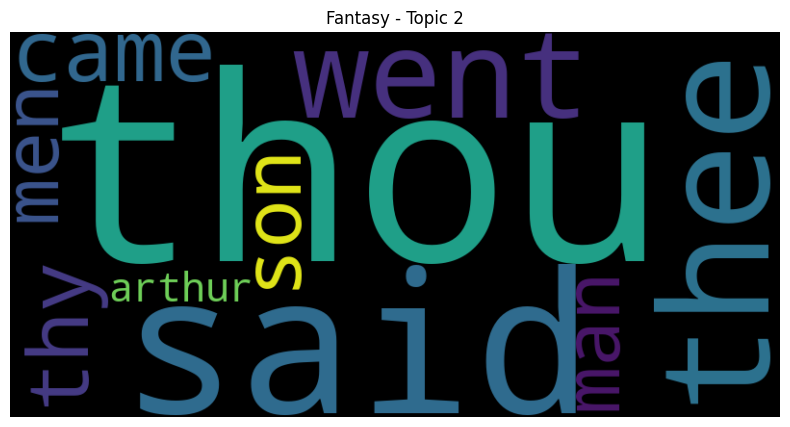

Topic 3:
thou robin said thee myles little thy good quoth john


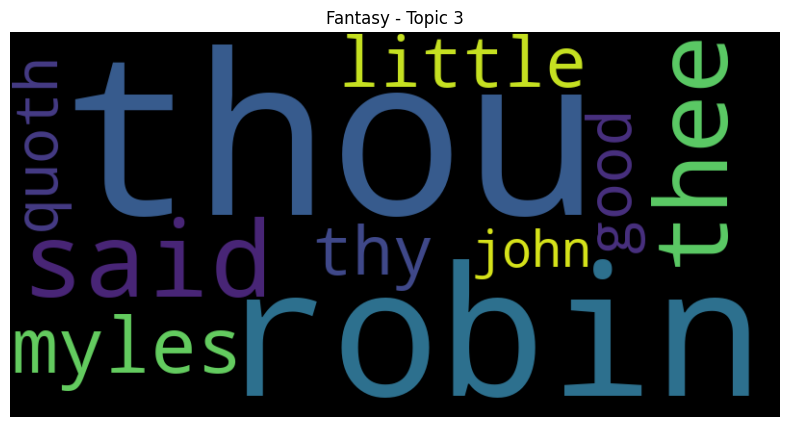

Topic 4:
sir king said knight came thou great arthur ye fionn


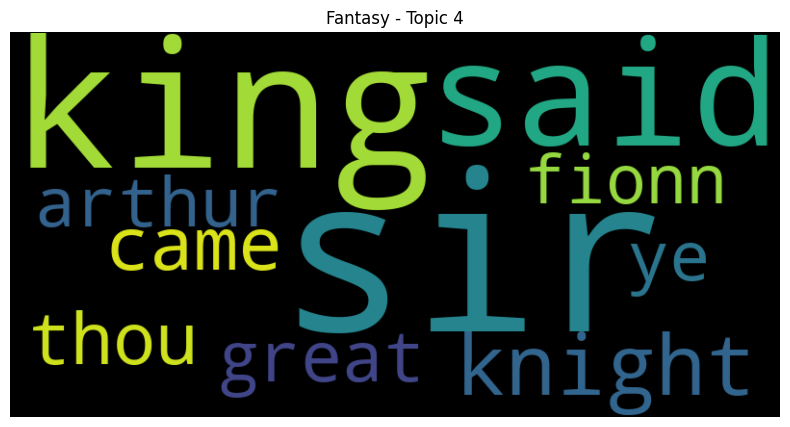

Topic 5:
said little dorothy gutenberg project people man like old came


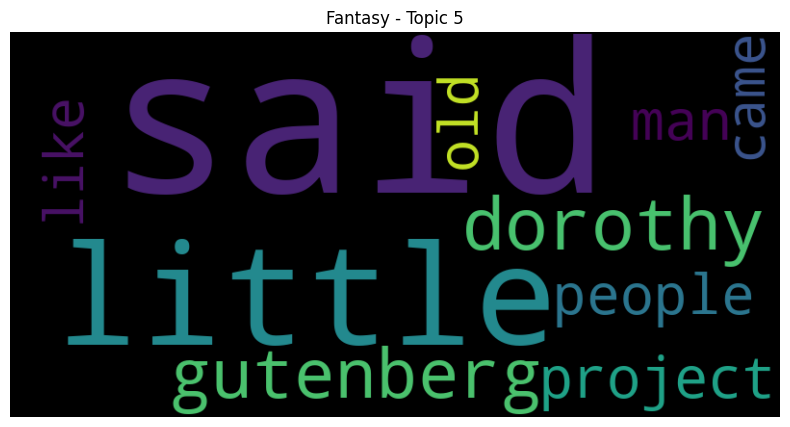


--- Topics for Subgenre: Mystery_Fiction ---
Topic 1:
said sir percival time miss mr house man count little


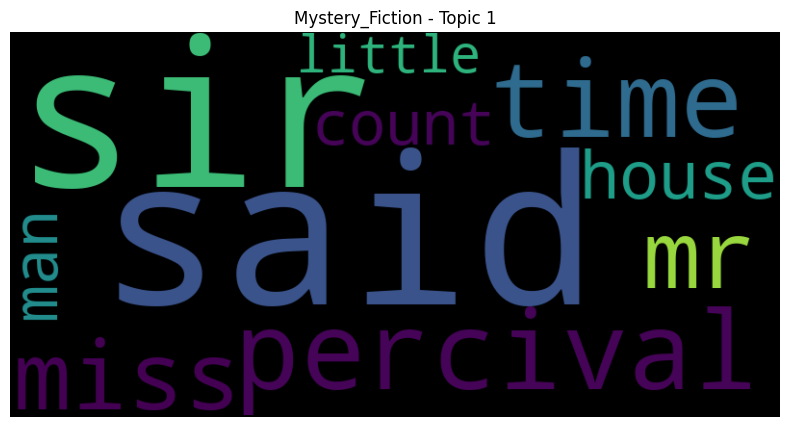

Topic 2:
said man like know time did come came good got


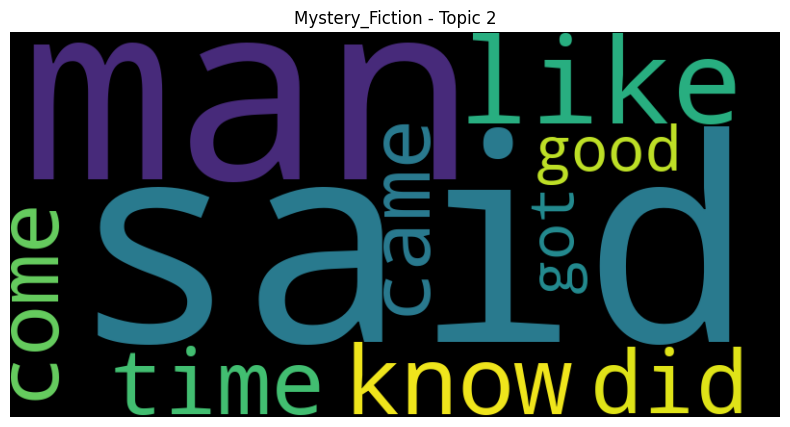

Topic 3:
mr said time franklin miss sergeant rachel house lady way


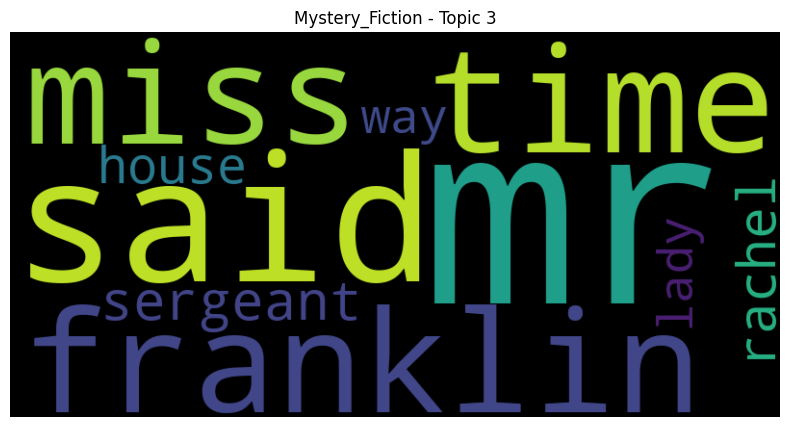

Topic 4:
said time little say great man long gutenberg having project


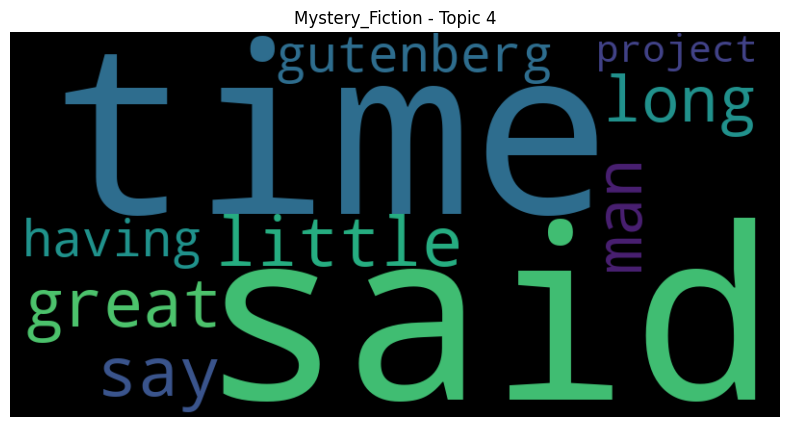

Topic 5:
verloc mr mrs man said like did inspector chief time


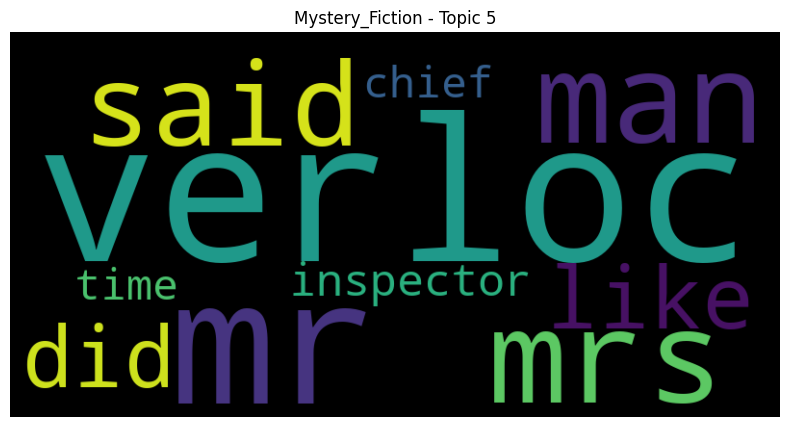


--- Topics for Subgenre: Science_Fiction ---
Topic 1:
gutenberg project work works hendricks electronic foundation time great dejah


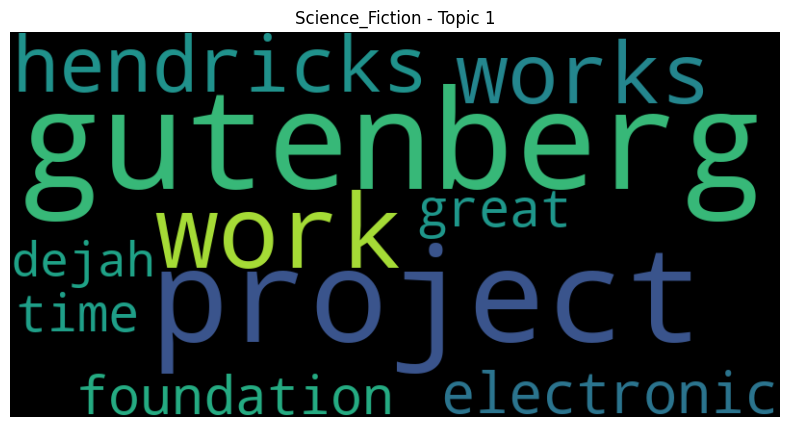

Topic 2:
said little man came time like went saw did mr


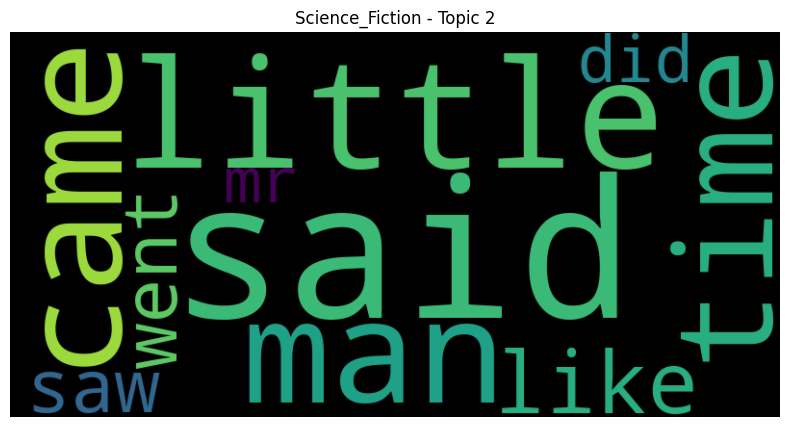

Topic 3:
captain pencroft harding said island replied sea herbert nautilus cyrus


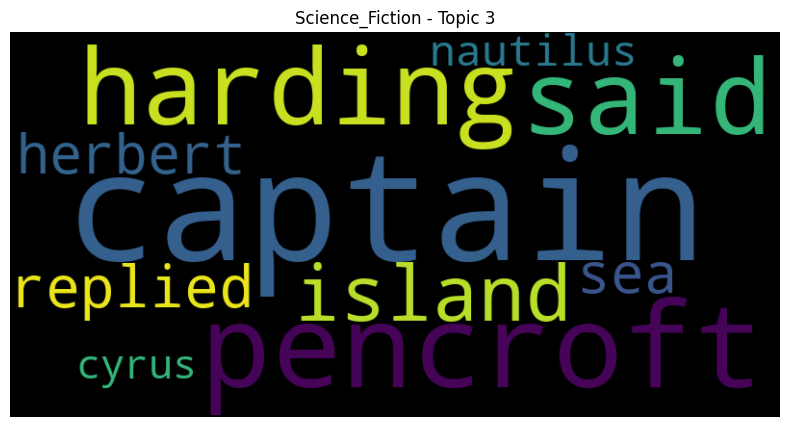

Topic 4:
said challenger professor great summerlee lord john man like come


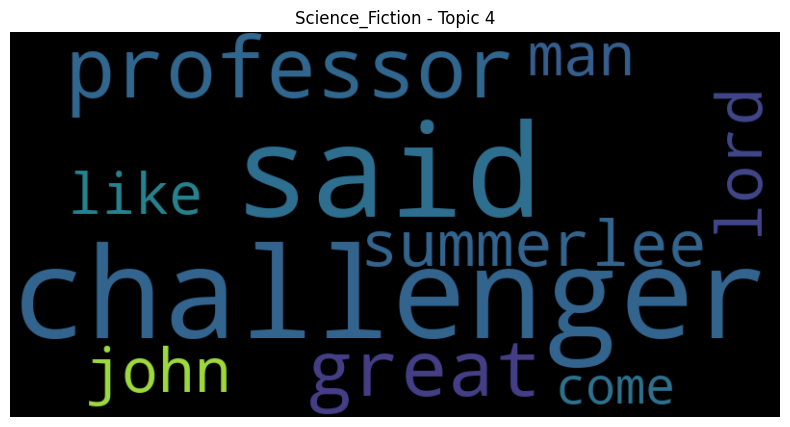

Topic 5:
kennon said alexander ll lani copper like know man don


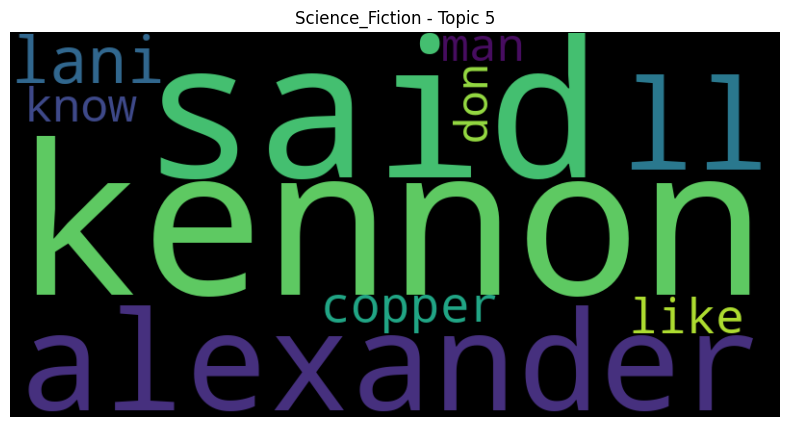

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

# Base directory containing the genres
base_dir = 'gutenberg_bookshelf_data'

# Process each subgenre
for genre_folder in os.listdir(base_dir):
    genre_path = os.path.join(base_dir, genre_folder, 'cleaned')
    if not os.path.exists(genre_path):
        continue

    # Combine all texts for the current subgenre
    book_texts = []
    for filename in os.listdir(genre_path):
        if filename.endswith('.txt'):
            with open(os.path.join(genre_path, filename), 'r', encoding='utf-8') as f:
                book_texts.append(f.read())

    if not book_texts:  # Skip if no texts are found
        print(f"No texts found for genre: {genre_folder}")
        continue

    # Vectorize the combined text
    vectorizer = CountVectorizer(max_features=2000, stop_words='english')
    X = vectorizer.fit_transform(book_texts)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components as needed
    lda.fit(X)

    # Display topics
    print(f"\n--- Topics for Subgenre: {genre_folder} ---")
    words = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([words[i] for i in topic.argsort()[-10:][::-1]]))

        # Generate word cloud for the topic
        topic_words = {words[i]: topic[i] for i in topic.argsort()[-10:]}  # Top 10 words
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(topic_words)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{genre_folder} - Topic {topic_idx + 1}")
        plt.show()

